# Исследование сервиса аренды самокатов GoFast

Проводим анализ сервиса аренды самокатов GoFast на основе данных о некоторых пользователях из нескольких городов, а также об их поездках. Анализируем данные и проверяем некоторые гипотезы, которые могут помочь бизнесу вырасти.\
Чтобы совершать поездки по городу, пользователи сервиса GoFast пользуются мобильным приложением.\
Сервисом можно пользоваться:\
• без подписки
- абонентская плата отсутствует;
- стоимость одной минуты поездки — 8 рублей;
- стоимость старта (начала поездки) — 50 рублей;

• с подпиской Ultra
- абонентская плата — 199 рублей в месяц;
- стоимость одной минуты поездки — 6 рублей;
- стоимость старта — бесплатно.
\
<b> Цели исследования: </b>\
    1) Определяем целевые аудитории клиентов и расспределение их по городам.
    2) Рассмотрим соотношение пользователей с разными типами подписки и их показатели. 
    3) Проверим гипотезы, которые могут помочь в развитии бизнеса. 
    
    "Сырые данные" представлены в виде 3 таблиц, и неизвестно какого качества информация в них содержиться. Поэтому, план работы будет следующим:\
    <b>Исследование пройдет в 7 этапов:</b>
    - Обзор данных
    - Предобработка
    - Исследовательский анализ данных
    - Объединение таблиц в одну, а так же разделение ее на 2 датафрейма по типам подписки для визуализации их соотношения к друг другу.
    - Подсчет и анализ помесячной выручки.
    - Проверка гипотез. 
    - Общий вывод. 


In [423]:
import pandas as pd

In [424]:
import matplotlib.pyplot as plt

In [425]:
import numpy as np

In [426]:
from scipy import stats as st

In [427]:
from scipy.stats import binom, poisson

In [428]:
from math import sqrt

#### Загрузка данных

In [429]:
df_users=pd.read_csv('/datasets/users_go.csv')
display(df_users.head())

,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra


In [430]:
df_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB


In [431]:
df_rides=pd.read_csv('/datasets/rides_go.csv')
display(df_rides.head())

,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28


In [432]:
df_rides.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 564.8+ KB


In [433]:
df_subscriptions=pd.read_csv('/datasets/subscriptions_go.csv')
display(df_subscriptions.head())

,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


In [434]:
df_subscriptions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subscription_type  2 non-null      object
 1   minute_price       2 non-null      int64 
 2   start_ride_price   2 non-null      int64 
 3   subscription_fee   2 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 192.0+ bytes


Загружено 3 таблицы с информацией о пользователях, их данных и типе подписки; информацией о продолжительности и длине поездки; таблица со стоимостью услуг и тарифом подписки. Все таблицы можно объединить в 1. 

####  Предобработка данных

In [435]:
df_rides['date'] = pd.to_datetime(df_rides['date'],format='%Y-%m-%d')
display(df_rides.head())

,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28


In [436]:
df_rides.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   18068 non-null  int64         
 1   distance  18068 non-null  float64       
 2   duration  18068 non-null  float64       
 3   date      18068 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(2), int64(1)
memory usage: 564.8 KB


Данные в колонке "date" приведены к корректному формату даты. 

In [437]:
df_rides['month'] = pd.DatetimeIndex(df_rides['date']).month
display(df_rides)

,user_id,distance,duration,date,month
0,1,4409.919140,25.599769,2021-01-01,1
1,1,2617.592153,15.816871,2021-01-18,1
2,1,754.159807,6.232113,2021-04-20,4
3,1,2694.783254,18.511000,2021-08-11,8
4,1,4028.687306,26.265803,2021-08-28,8
...,...,...,...,...,...
18063,1534,3781.098080,19.822962,2021-11-04,11
18064,1534,2840.423057,21.409799,2021-11-16,11
18065,1534,3826.185507,18.435051,2021-11-18,11
18066,1534,2902.308661,16.674362,2021-11-27,11


In [438]:
#df_rides['year'] = pd.DatetimeIndex(df_rides['date']).year
#df_rides['year'].unique()


Данные представлены только за 2021 год, поэтому каждый месяц будет уникален. Для дальнейших расчетов выделена отдельная колонка с номером месяца. 

Проверим данные на пропуски и дубликаты:

In [439]:
df_users.isna().sum()

user_id              0
name                 0
age                  0
city                 0
subscription_type    0
dtype: int64

Пропусков нет.

In [440]:
df_users.duplicated().sum()

31

In [441]:
df_users=df_users.drop_duplicates()
df_users.duplicated().sum()

0

Был найден 31 полный дубликат и удален. 

In [442]:
df_rides.isna().sum()

user_id     0
distance    0
duration    0
date        0
month       0
dtype: int64

In [443]:
df_rides.duplicated().sum()

0

In [444]:
df_subscriptions.isna().sum()

subscription_type    0
minute_price         0
start_ride_price     0
subscription_fee     0
dtype: int64

In [445]:
df_subscriptions.duplicated().sum()

0

В остальных данных пропусков и дубликатов найдено не было. 

Вывод: Данные собираются очень качественно - нет пропусков, кол-во дубликатов минимальное. 

####  Исследовательский анализ данных

##### Исследование частоты встречаемости городов

Пятигорск         219
Екатеринбург      204
Ростов-на-Дону    198
Краснодар         193
Сочи              189
Омск              183
Тюмень            180
Москва            168
Name: city, dtype: int64

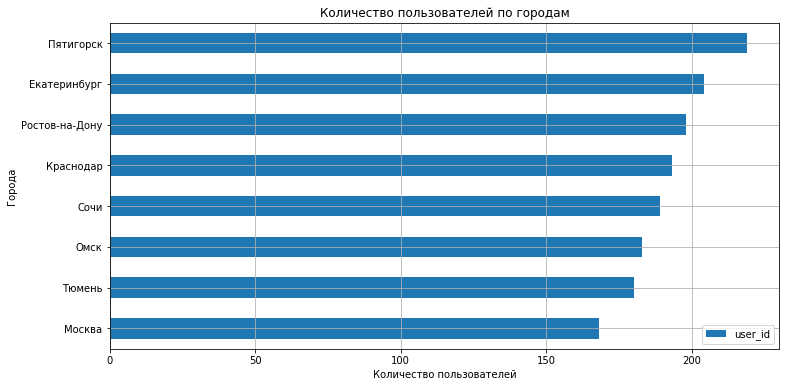

In [446]:
display(df_users['city'].value_counts()) 
(df_users.pivot_table(index='city', values='user_id', aggfunc='count').sort_values(by='user_id')
    .plot(kind='barh', grid=True, figsize=(12, 6))
)
plt.title('Количество пользователей по городам')
plt.ylabel('Города')
plt.xlabel('Количество пользователей')
plt.show()

Больше всего пользователей в Пятигорске, после него самый многочисленный - Екатеринбург. Меньше всего пользователей в Москве. Возможно, это связано с высокой конкуренцией в этом сегменте в столице. 

##### Cоотношение пользователей с подпиской и без подписки

free     835
ultra    699
Name: subscription_type, dtype: int64

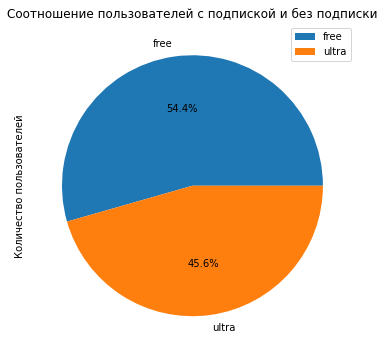

In [447]:
display(df_users['subscription_type'].value_counts()) 
(df_users.pivot_table(index='subscription_type', values='user_id', aggfunc='count')
    .plot(kind='pie', y= 'user_id', autopct='%1.1f%%', figsize=(12,6))
)
plt.title('Cоотношение пользователей с подпиской и без подписки')
plt.ylabel('Количество пользователей')
plt.show()

Пользователей с подпиской - 54.4%, без подписки - 45.6%

#####  Исследование возраста пользователей

Средний возраст клиентов: 24.9


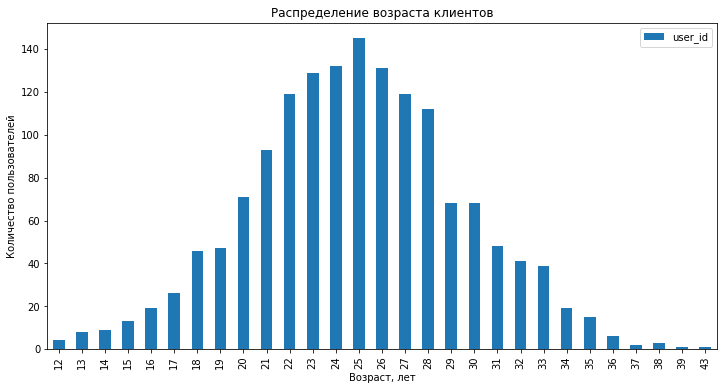

In [448]:
#display(df_users['age'].value_counts())
print('Средний возраст клиентов:', round(df_users['age'].mean(), 1))
(df_users.pivot_table(index='age', values='user_id', aggfunc='count').sort_values(by='age')
    .plot(kind='bar', figsize=(12, 6))
)
plt.title('Распределение возраста клиентов')
plt.xlabel('Возраст, лет')
plt.ylabel('Количество пользователей')
plt.show()

Средний возраст клиентов равен 24.9 лет. Самая многочисленная группа пользователей от 21 до 28 лет. Их можно выделить как целевую аудиторию. 

##### Исcледование расстояния, которое пользователь преодолел за одну поездку

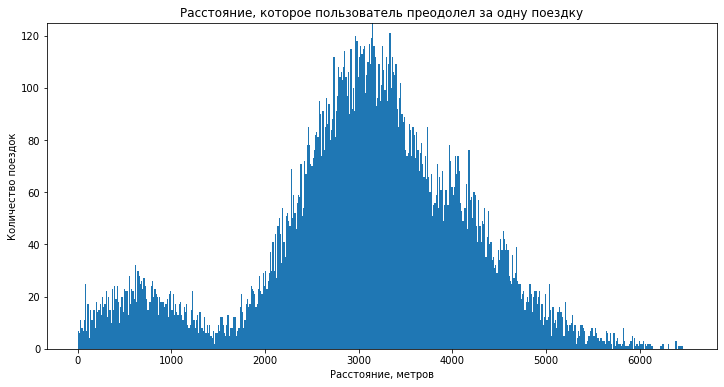

Средняя дальность поездки: 3133.61 метров


In [449]:
df_rides['distance'].plot(kind='hist', bins=500, range=(0, 6500), figsize=(12, 6))
plt.ylim(0, 125)
plt.title('Расстояние, которое пользователь преодолел за одну поездку')
plt.xlabel('Расстояние, метров')
plt.ylabel('Количество поездок')
plt.show()
print('Средняя дальность поездки:', round(df_rides['distance'].median(), 2), 'метров')

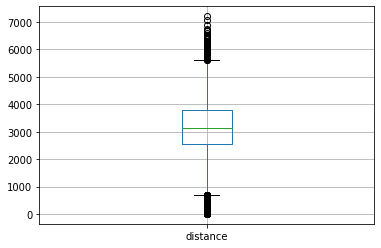

In [450]:
df_rides.boxplot('distance')
plt.show()

На графике видно, что есть 2 пика популярноости: кол-во поездок увеличивается к показателю 700 метров и после снижается к 1.5 км, потом начинается резкий рост с пиком около 3 км. Поездок больше 6 км практически нет. Среднее растояние поездок - 3,133 км. Это подтверждается диаграммой размаха. 

#####  Исследование продолжительности поездок

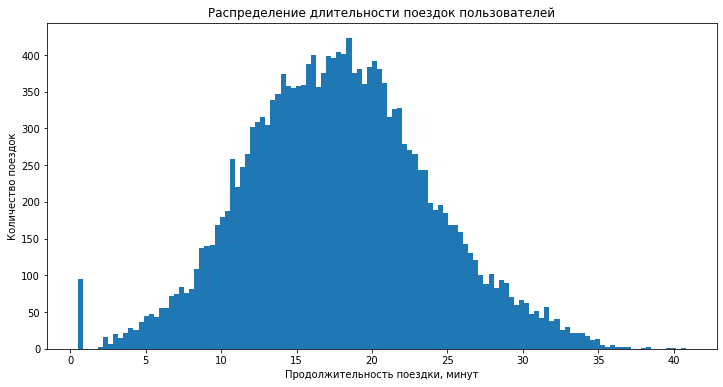

Средняя длительность поездки: 17.68 минут


In [451]:
df_rides['duration'].plot(kind='hist', bins=120, figsize=(12, 6))
plt.title('Распределение длительности поездок пользователей')
plt.xlabel('Продолжительность поездки, минут')
plt.ylabel('Количество поездок')
plt.show()
print('Средняя длительность поездки:', round(df_rides['duration'].median(), 2), 'минут')

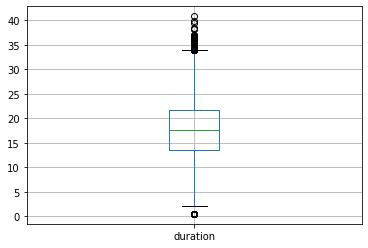

In [452]:
df_rides.boxplot('duration')
plt.show()

На графике видно, что рапределение близко к нормальному, есть только один явный выброс рядом с 0 - почти 100 очень коротких поездок. Скорее всего они связаны с пиком около 700 м. на предыдущем графике. Пользователи проезжали очень короткое растояние очень быстро. Это может быть связано с необходимостью быстро добраться до необходимой точки из-за опоздания, или пользователи, которые воспользовались услугами остались чем-либо недовольны и прекратили поездку. Этот вопрос можно исследовать дополнительно.\
Средняя длительность поездок - примерно 17,5 минут.\
Поездок дольше 35 минут практически нет. 

####  Объединение данных

Для дальнейших вычислений объединим три таблицы в одну:

In [453]:
df_users.shape

(1534, 5)

In [454]:
df_rides.shape

(18068, 5)

In [455]:
df_subscriptions.shape

(2, 4)

In [456]:
df_total = df_users.merge(
    df_rides,
    on='user_id',
    how='inner'
)
df_total = df_total.merge(
    df_subscriptions,
    on='subscription_type',
    how='inner'
)
display(df_total.head())

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,4409.919140,25.599769,2021-01-01,1,6,0,199
1,1,Кира,22,Тюмень,ultra,2617.592153,15.816871,2021-01-18,1,6,0,199
2,1,Кира,22,Тюмень,ultra,754.159807,6.232113,2021-04-20,4,6,0,199
3,1,Кира,22,Тюмень,ultra,2694.783254,18.511000,2021-08-11,8,6,0,199
4,1,Кира,22,Тюмень,ultra,4028.687306,26.265803,2021-08-28,8,6,0,199


In [457]:
df_total.shape

(18068, 12)

Новый датафрейм создан корректно - кол-во колонок и строк совпадает с ожидаемым. 

##### Создание отдельных датафреймов для групп пользлвателей по типу подписки

In [458]:
cusomer_free = df_total.query('subscription_type == "free"')
display(cusomer_free.head())

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
6500,700,Айдар,22,Омск,free,2515.690719,14.944286,2021-01-02,1,8,50,0
6501,700,Айдар,22,Омск,free,846.932642,16.234663,2021-02-01,2,8,50,0
6502,700,Айдар,22,Омск,free,4004.434142,20.016628,2021-02-04,2,8,50,0
6503,700,Айдар,22,Омск,free,1205.911290,9.782872,2021-02-10,2,8,50,0
6504,700,Айдар,22,Омск,free,3047.379435,17.427673,2021-02-14,2,8,50,0


Датафрейм для пользователей без подписки создан. 

In [459]:
cusomer_ultra = df_total.query('subscription_type == "ultra"')
display(cusomer_ultra.head())

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,4409.919140,25.599769,2021-01-01,1,6,0,199
1,1,Кира,22,Тюмень,ultra,2617.592153,15.816871,2021-01-18,1,6,0,199
2,1,Кира,22,Тюмень,ultra,754.159807,6.232113,2021-04-20,4,6,0,199
3,1,Кира,22,Тюмень,ultra,2694.783254,18.511000,2021-08-11,8,6,0,199
4,1,Кира,22,Тюмень,ultra,4028.687306,26.265803,2021-08-28,8,6,0,199


Датафрейм для пользователей с подпиской создан. 

#####  Визуализируем информацию о расстоянии и времени поездок для пользователей обеих категорий.

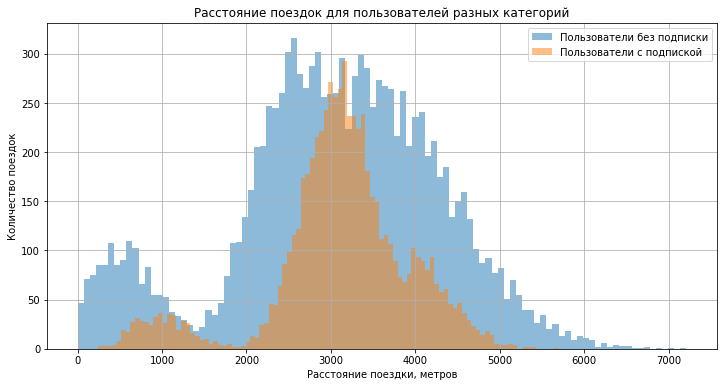

count    11568.000000
mean      3045.495282
std       1246.173806
min          0.855683
25%       2366.562689
50%       3114.648465
75%       3905.697894
max       7211.007745
Name: distance, dtype: float64

count    6500.000000
mean     3115.445388
std       836.895330
min       244.210438
25%      2785.444017
50%      3148.637229
75%      3560.574425
max      5699.769662
Name: distance, dtype: float64

In [460]:
cusomer_free['distance'].plot(kind='hist', bins=100, alpha=0.5, grid='True', label='Пользователи без подписки', figsize=(12, 6))
cusomer_ultra['distance'].plot(kind='hist',bins=100, alpha=0.5, grid='True', label='Пользователи с подпиской', figsize=(12, 6))
plt.legend() 
plt.title('Расстояние поездок для пользователей разных категорий')
plt.xlabel('Расстояние поездки, метров')
plt.ylabel('Количество поездок')
plt.show()
display(cusomer_free['distance'].describe())
display(cusomer_ultra['distance'].describe())


Среднее и медиана двух наборов данных находятся достаточно близко друг к другу, но размах диаграмм показывает, что пользователи без подписки совершают больше поезок и на более длительные расстояния. И, также, у пользователей без подписки больше поездок на короткие расстояния. 

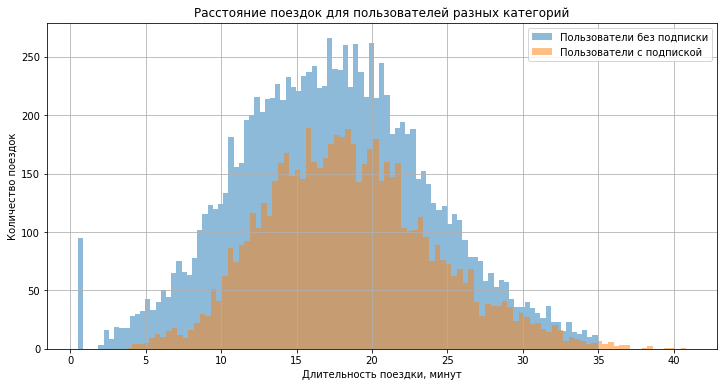

count    11568.000000
mean        17.390909
std          6.326803
min          0.500000
25%         12.958437
50%         17.326890
75%         21.594071
max         34.948498
Name: duration, dtype: float64

count    6500.000000
mean       18.541985
std         5.572048
min         3.760353
25%        14.524654
50%        18.178153
75%        21.884129
max        40.823963
Name: duration, dtype: float64

In [461]:
cusomer_free['duration'].plot(kind='hist', bins=100, alpha=0.5, grid='True', label='Пользователи без подписки', figsize=(12, 6))
cusomer_ultra['duration'].plot(kind='hist',bins=100, alpha=0.5, grid='True', label='Пользователи с подпиской', figsize=(12, 6))
plt.legend() 
plt.title('Расстояние поездок для пользователей разных категорий')
plt.xlabel('Длительность поездки, минут')
plt.ylabel('Количество поездок')
plt.show()

display(cusomer_free['duration'].describe())
display(cusomer_ultra['duration'].describe())

Среднее и медиана двух наборов данных на эом графике вновь расположены очень близко друг к другу. Но при этом минимальная длительность поездок у пользователей с подпиской выше, чем у тех, кто пользуется приложением без подписки: 3,7 минут и 0,5 минут. Максимальная длительность тоже меняется - пользователи без подписки ограничиваются длительностью поездки в 35 минут, когда пользователи с подпиской - 41 минуту. 

####  Подсчёт выручки

##### Создаем  датафрейм с агрегированными данными о поездках на основе датафрейма с объединёнными данными из шага 4: найдем суммарное расстояние, количество поездок и суммарное время для каждого пользователя за каждый месяц.

In [462]:
df_total['duration'] = np.ceil(df_total['duration'])  
agg_df = df_total.pivot_table(
    index=['user_id', 'month'],
    values=['distance', 'date', 'duration','minute_price', 'start_ride_price', 'subscription_fee'],
    aggfunc={'distance':sum, 'date':'count', 'duration':sum, 'minute_price': 'mean',\
             'start_ride_price':'mean','subscription_fee':'mean'}
)
display(agg_df.head())

date     distance  duration  minute_price  start_ride_price  \
user_id month                                                                
1       1         2  7027.511294      42.0             6                 0   
        4         1   754.159807       7.0             6                 0   
        8         2  6723.470560      46.0             6                 0   
        10        2  5809.911100      32.0             6                 0   
        11        3  7003.499363      56.0             6                 0   

               subscription_fee  
user_id month                    
1       1                   199  
        4                   199  
        8                   199  
        10                  199  
        11                  199

In [463]:
agg_df.columns = ['count','total_distance', 'total_duration', 'minute_price', 'start_ride_price', 'subscription_fee']
agg_df.reset_index()

,user_id,month,count,total_distance,total_duration,minute_price,start_ride_price,subscription_fee
0,1,1,2,7027.511294,42.0,6,0,199
1,1,4,1,754.159807,7.0,6,0,199
2,1,8,2,6723.470560,46.0,6,0,199
3,1,10,2,5809.911100,32.0,6,0,199
4,1,11,3,7003.499363,56.0,6,0,199
...,...,...,...,...,...,...,...,...
11326,1534,6,2,3409.468534,26.0,8,50,0
11327,1534,8,2,7622.453034,48.0,8,50,0
11328,1534,9,1,4928.173852,23.0,8,50,0
11329,1534,11,4,13350.015305,78.0,8,50,0


In [464]:
agg_df.isna().sum()

count               0
total_distance      0
total_duration      0
minute_price        0
start_ride_price    0
subscription_fee    0
dtype: int64

Успешно создан датафрейм с суммарными расстоянием и длительностью поездки, кол-вом поездок для каждого пользователя помесячно. 

##### Добавление столбцов с помесячной выручкой для каждого пользователя

In [465]:
agg_df['revenue'] = agg_df['start_ride_price']* agg_df['count']\
+ agg_df['minute_price'] * agg_df['total_duration'] + agg_df['subscription_fee']
display(agg_df.head())

count  total_distance  total_duration  minute_price  \
user_id month                                                        
1       1          2     7027.511294            42.0             6   
        4          1      754.159807             7.0             6   
        8          2     6723.470560            46.0             6   
        10         2     5809.911100            32.0             6   
        11         3     7003.499363            56.0             6   

               start_ride_price  subscription_fee  revenue  
user_id month                                               
1       1                     0               199    451.0  
        4                     0               199    241.0  
        8                     0               199    475.0  
        10                    0               199    391.0  
        11                    0               199    535.0

Добавлен столбец "revenue" с выручкой для каждого пользователя помесячно. 

#### Проверка гипотез

Продакт-менеджеры сервиса хотят увеличить количество пользователей с подпиской. Для этого они будут проводить различные акции, но сначала нужно выяснить несколько важных моментов.

##### Гипотеза 1: тратят ли пользователи с подпиской больше времени на поездки, чем пользователи без подписки.

Важно понять, тратят ли пользователи с подпиской больше времени на поездки? Если да, то пользователи с подпиской могут быть «выгоднее» для компании.\
Нулевая гипотеза(H0): Длительность поездок пользователей с подпиской равно длитильности поездок у пользователей без подписки (cusomer_ultra['duration'] = cusomer_free['duration']).\
Альтернативная гипотеза(H1): Длительность поездок пользователей с подпиской больше длитильности поездок у пользователей без подписки (cusomer_ultra['duration']>cusomer_free['duration']).

In [466]:
alpha = 0.05

results = st.ttest_ind(
    cusomer_ultra['duration'], 
    cusomer_free['duration'], 
    equal_var=True, 
    alternative='greater')
print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение: 1.2804098316645618e-34
Отвергаем нулевую гипотезу


Тест показал, что нулевая гипотеза отвергнута в пользу альтернативной, т.е. длительность поездок пользователей с подпиской больше чем длительность поездок клиентов без подписки. 

##### Гипотеза 2: Среднее растояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров.

Расстояние одной поездки в 3130 метров — оптимальное с точки зрения износа самоката. Можно ли сказать, что среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров?

Нулевая гипотеза(H0): Среднее растояние, которое проезжают пользователи с подпиской за одну поездку равно 3130 метров. cusomer_ultra['distance']=3130\
Альтернативная гипотеза(H1): Среднее растояние, которое проезжают пользователи с подпиской за одну поездку ,больше 3130 метров.  cusomer_ultra['distance']>3130

In [467]:
alpha = 0.05
prev_distance_value = 3130
results = st.ttest_1samp(
    cusomer_ultra['distance'],
    prev_distance_value,
    alternative='greater')
print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение: 0.9195368847849785
Не получилось отвергнуть нулевую гипотезу


Нулевую гипотезу не отвергли, соответственно можно сказать, что среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров. 

##### Гипотеза 3: будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки

Проверяем гипотезу о том, будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки. 

Нулевая гипотеза(H0): Помесячная выручка от пользователей с подпиской по месяцам равна выручке от пользователей без подписки (agg_df.query('subscription_fee == 199')['revenue']=agg_df.query('subscription_fee == 0')['revenue'])\
Альтернативная гипотеза(H1): Помесячная выручка от пользователей с подпиской по месяцам превышает выручку от пользователей без подписки (agg_df.query('subscription_fee == 199')['revenue']>agg_df.query('subscription_fee == 0')['revenue'])

In [468]:
alpha = 0.05

results = st.ttest_ind(
    agg_df.query('subscription_fee == 199')['revenue'], 
    agg_df.query('subscription_fee == 0')['revenue'], 
    equal_var=True, 
    alternative='greater')
print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение: 1.8850394384715216e-31
Отвергаем нулевую гипотезу


Нулевая гипотеза отвергута, соответственно можно сделать вывод о том, что помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки.

##### Представьте такую ситуацию: техническая команда сервиса обновила сервера, с которыми взаимодействует мобильное приложение. Она надеется, что из-за этого количество обращений в техподдержку значимо снизилось. Некоторый файл содержит для каждого пользователя данные о количестве обращений до обновления и после него. Какой тест вам понадобился бы для проверки этой гипотезы?

Т.к. дана одна генеральная совокупность, которую изучаем - база данных клиентов сервиса и 2 связанных показателя, то нужно использовать тест scipy.stats.ttest_rel. Аргументы: наборы данных — парные выборки до и после изменения. 

#### Вывод: 

1. На предобработке данных не было обнаружено пропусков и были найдено небольшое кол-во дубликатов - это говорит о хороших алгоритмах сбора информации. 
2. Больше всего пользователей в Пятигорске, после него самый многочисленный - Екатеринбург. Меньше всего пользователей в Москве. Возможно, это связано с высокой конкуренцией в этом сегменте в столице.
3. Соотношение пользователей с подпиской - 54.4%, к без подписки - 45.6%
4. Средний возраст клиентов равен 24.9 лет. Самая многочисленная группа пользователей от 21 до 28 лет. Их можно выделить как целевую аудиторию.
5. Средняя дальность 1 поездки: 3133.61 метров. На графике видно, что есть 2 пика популярноости: кол-во поездок увеличивается к показателю 700 метров и после снижается к 1.5 км, потом начинается резкий рост с пиком около 3 км. Поездок больше 6 км практически нет. Среднее растояние поездок - 3,133 км.
6. Средняя длительность поездки: 17.68 минут
7. На графике видно, что рапределение близко к нормальному, есть только один явный выброс рядом с 0 - почти 100 очень коротких поездок. Скорее всего они связаны с пиком около 700 м. на предыдущем графике. Пользователи проезжали очень короткое растояние очень быстро. Это может быть связано с необходимостью быстро добраться до необходимой точки из-за опоздания, или пользователи, которые воспользовались услугами остались чем-либо недовольны и прекратили поездку. Этот вопрос можно исследовать дополнительно. Средняя длительность поездок - примерно 17,5 минут. Поездок дольше 35 минут практически нет.
8. При изучении данных пользователей с подпиской и без нее по длительности и расстоянию поездок, выявили: Среднее и медиана двух наборов данных на этом графике расположены очень близко друг к другу. Но при этом минимальная длительность поездок у пользователей с подпиской выше, чем у тех, кто пользуется приложением без подписки: 3,7 минут и 0,5 минут. Максимальная длительность тоже меняется - пользователи без подписки ограничиваются длительностью поездки в 35 минут, когда пользователи с подпиской - 41 минуту. Пользователи без подписки совершают больше поезок и на более длительные расстояния. И, также, у пользователей без подписки больше поездок на короткие расстояния.
9. При проверке гипотез определено: 
- длительность поездок пользователей с подпиской больше чем длительность поездок клиентов без подписки.
- среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров.
- помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки.\
\
<b>Рекомендации:</b>\
- В ходе исследования была выявлено, что клиенты с подпиской приносят больший доход. Поэтому предлагаю сфокусироваться на привлечении новых подписчиков. Для этого можно проводить промоакции для пользователей без подписки, а так же повысить узнаваемость приложения среди потенциальных пользователей приложения. Целевая аудитория - от 21 до 28 лет.\
- Рекомендуется провести конкурентный анализ и выяснить, почему в самом большом городе (Москве) так мало пользователей.\
- При изучении данных было отнаружено множество очень коротких поездок среди пользователей без подписки - это может быть связано с неудовлетворенностью клиентов в услуге или другими причинами. Для предотвращения рисков, необходимо дополнительно исучить эти показатели (возможно провести тестирование). 